In [79]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import export_graphviz 
import graphviz
from sklearn.tree import export_text
import matplotlib.pyplot as plt
from scipy.io import loadmat



In [80]:
data = pd.read_csv('MC_Modeled_spectra.csv')

In [81]:
X, Y = pd.DataFrame(), pd.DataFrame()
for i, column in enumerate(data.columns):
    #read only wavelengths from 510 nm to 720 nm
    if column.isnumeric() and i >= 46 and i<= 67  :
        X[column] = data[column]
    elif column == 'Mel' or column == 'BlSDBN':
        Y[column] = data[column]

### Split data into training and test datasets using a 80-20 split

In [82]:
Y_out = Y.values.reshape(-1,2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_out, test_size=.2, random_state=41)
print('X train',X_train.shape,'Y train', Y_train.shape,'X test', X_test.shape,'Y test', Y_test.shape)

X train (174960, 22) Y train (174960, 2) X test (43740, 22) Y test (43740, 2)


### Generate 3 different models with varying max depth of Decision Tree

In [83]:
# create a regressor object with max depth 30
regressor_0 = DecisionTreeRegressor(random_state = 0, max_depth = 30)
# fit the regressor with X and Y data
regressor_0.fit(X_train, Y_train)

# create a regressor object with max depth 15
regressor_1 = DecisionTreeRegressor(random_state = 0, max_depth = 15)
# fit the regressor with X and Y data
regressor_1.fit(X_train, Y_train)

# create a regressor object with max depth 19
regressor_2 = DecisionTreeRegressor(random_state = 0, max_depth = 9)
# fit the regressor with X and Y data
regressor_2.fit(X_train, Y_train)


DecisionTreeRegressor(max_depth=9, random_state=0)

In [84]:
def predictAccuracy(regressor):
    y_pred = regressor.predict(X_test)

    MSE_Mel = mean_squared_error(Y_test[:,0], y_pred[:,0])
    MSE_Oxy = mean_squared_error(Y_test[:,1], y_pred[:,1])
    print(f'MSE Melanin: {MSE_Mel}, MSE BloodOxSat: {MSE_Oxy}')


    R2_Mel = r2_score(Y_test[:,0], y_pred[:,0])
    R2_Oxy = r2_score(Y_test[:,1], y_pred[:,1])
    print(f'R2 Melanin: {R2_Mel}, R2 BloodOxSat: {R2_Oxy}')
    return MSE_Mel, MSE_Oxy, R2_Mel, R2_Oxy

In [85]:
MSE_Mel1 , MSE_Ox1, R2_Mel1, R2_Oxy1 = predictAccuracy(regressor_0)
MSE_Mel2 , MSE_Ox2, R2_Mel2, R2_Oxy2 = predictAccuracy(regressor_1)
MSE_Mel3 , MSE_Ox3, R2_Mel3, R2_Oxy3 = predictAccuracy(regressor_2)

MSE Melanin: 0.0003771235232552681, MSE BloodOxSat: 0.0046891328350227
R2 Melanin: 0.9279576640472428, R2 BloodOxSat: 0.3560123949451859
MSE Melanin: 0.00040575873419503337, MSE BloodOxSat: 0.005113385042626199
R2 Melanin: 0.9224874471040152, R2 BloodOxSat: 0.2977472161314847
MSE Melanin: 0.0005369518473924667, MSE BloodOxSat: 0.006422157112109445
R2 Melanin: 0.8974254773438842, R2 BloodOxSat: 0.11800545571597532


### Testing with HSI data

In [86]:
folder = "Data_Mike";
filename = "R_(1measurement)_normalized_NoGap[202,202,79].mat";
folder = folder + "/";
data_file_to_load = folder + filename;
HSI_Data= loadmat(data_file_to_load);
Hyperspectra_data = HSI_Data['R1']
Hyperspectra_data[np.isinf(Hyperspectra_data)] = 0
Hyperspectra_data_resized = Hyperspectra_data[:,:, 0:43:2]; # Get from 510 to 720 nm with 10nm step size
(x_total, y_total, wavelenght) = Hyperspectra_data_resized.shape;
print("Hyperspectral data: x_total", x_total, "y_total", y_total, "wavelenth",wavelenght);
Hyperspectra_data_reshaped = Hyperspectra_data_resized.reshape(x_total*y_total,-1).astype(np.float32)

print("Hyperspectral reshaped size",Hyperspectra_data_reshaped.shape)


Hyperspectral data: x_total 202 y_total 202 wavelenth 22
Hyperspectral reshaped size (40804, 22)


### Prediction of Melanin using the trained MLP model
#### wrt baseline cross-correlation


In [87]:
Results = np.load("R_(1measurement)_normalized_NoGap[202,202,79].matData_small.csv.npy");
x_total  = 202;
y_total  = 202;

# Melanin in living epidermis

Mel_True = Results[:,:,4].reshape(x_total * y_total, -1 );

# Blood Saturation in DBN

Blood_BISDBN_True =  Results[:,:,10].reshape(x_total * y_total, -1 );
print(Mel_True.shape, Blood_BISDBN_True.shape)


(40804, 1) (40804, 1)


In [88]:
HSI_predictions = regressor_0.predict(Hyperspectra_data_reshaped)

MSE_Melanin = mean_squared_error(Mel_True[:,0], HSI_predictions[:,0])
MSE_BloodOx = mean_squared_error(Blood_BISDBN_True[:,0], HSI_predictions[:,1])
print(f'MSE Melanin : {MSE_Melanin}, MSE BloodOxSat: {MSE_BloodOx}')


R2_Mel = r2_score(Mel_True[:,0], HSI_predictions[:,0])
R2_Oxy = r2_score(Blood_BISDBN_True[:,0], HSI_predictions[:,1])
print(f'R2 Melanin: {R2_Mel}, R2 BloodOxSat: {R2_Oxy}')

MSE Melanin : 0.007707384079992157, MSE BloodOxSat: 0.0338880992059602
R2 Melanin: -0.3082433505752782, R2 BloodOxSat: -5.46116554131893


/Users/brijeshbv/opt/miniconda3/envs/mc-cnn-nn/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [89]:
HSI_predictions_reshaped = HSI_predictions.reshape(x_total, y_total,-1)
HSI_predictions_reshaped.shape

(202, 202, 2)

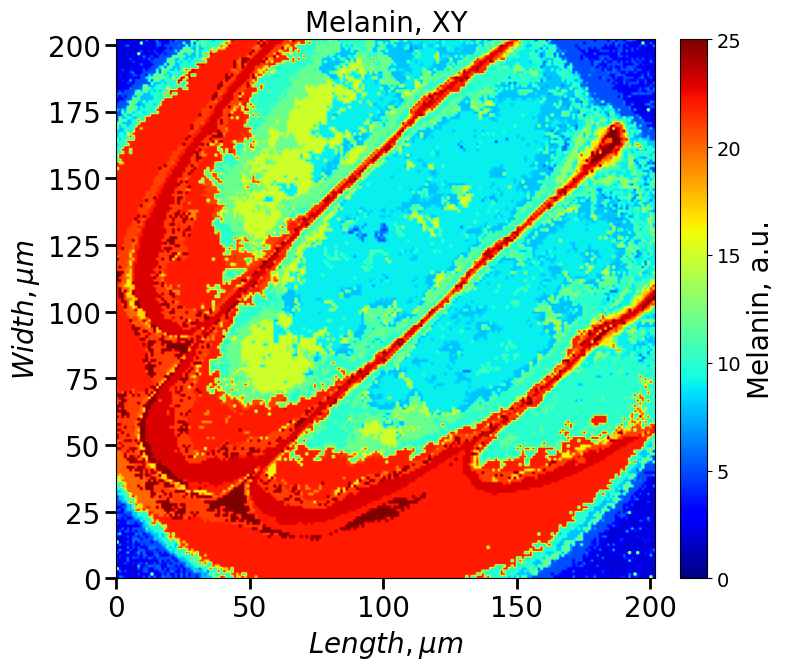

In [90]:
fig_mel = plt.figure(figsize=(8,7));
ax_mel = fig_mel.add_subplot(111);
plot_mel = ax_mel.imshow(HSI_predictions_reshaped[:,:,0] * 100, extent=(0,x_total,0,y_total), cmap='jet');
ax_mel.set_ylabel(r'$Width, \mu m$', fontsize=20);
ax_mel.set_xlabel(r'$Length, \mu m$', fontsize=20);
ax_mel.yaxis.set_ticks_position('left');
ax_mel.xaxis.set_ticks_position('bottom');
ax_mel.tick_params(axis='both',reset=False,which='both',length=8,width=2,labelsize=20);
ax_mel.set_title('Melanin, XY', fontsize=20);
plot_mel.set_clim(vmin=0, vmax=25.0);
cbar_mel = fig_mel.colorbar(plot_mel, fraction=0.046, pad=0.04);
cbar_mel.set_label('Melanin, a.u.',size=20);
cbar_mel.ax.tick_params(labelsize=14) ;
plt.show();

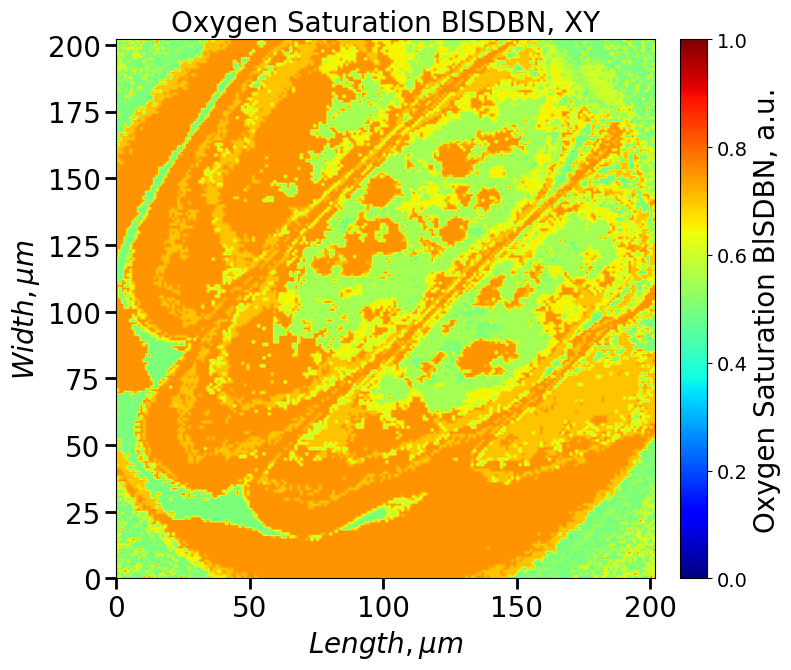

In [91]:

fig_blood_BlSDBN = plt.figure(figsize=(8,7));
ax_blood_BlSDBN = fig_blood_BlSDBN.add_subplot(111);
plot_blood_BlSDBN = ax_blood_BlSDBN.imshow(HSI_predictions_reshaped[:,:,1], extent=(0,x_total,0,y_total), cmap='jet');
ax_blood_BlSDBN.set_ylabel(r'$Width, \mu m$', fontsize=20);
ax_blood_BlSDBN.set_xlabel(r'$Length, \mu m$', fontsize=20);
ax_blood_BlSDBN.yaxis.set_ticks_position('left');
ax_blood_BlSDBN.xaxis.set_ticks_position('bottom');
ax_blood_BlSDBN.tick_params(axis='both',reset=False,which='both',length=8,width=2,labelsize=20);
ax_blood_BlSDBN.set_title('Oxygen Saturation BlSDBN, XY', fontsize=20);
plot_blood_BlSDBN.set_clim(vmin=0, vmax=1.0);
cbar_blood_BlSDBN = fig_blood_BlSDBN.colorbar(plot_blood_BlSDBN, fraction=0.046, pad=0.04);
cbar_blood_BlSDBN.set_label('Oxygen Saturation BlSDBN, a.u.',size=20);
cbar_blood_BlSDBN.ax.tick_params(labelsize=14) ;
plt.show();